In [1]:
!pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


In [2]:
import os
import gc
import cv2
import time
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from itertools import cycle
from tabulate import tabulate
from pandas import DataFrame
from keras import regularizers, optimizers, initializers

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
)
from sklearn.metrics import (
    roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, DenseNet121, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, 
    EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
def plot_class_samples(samples_count):
    labels = list(samples_count.keys())
    count = list(samples_count.values())
    
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(figsize =(18, 8))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()
    

In [4]:
# Data reading on Kaggle
image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'input', 'data', 'images*', 'images', '*.png'))}
df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
        "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

100%|█████████████████████████████████████████████████████| 112120/112120 [00:34<00:00, 3243.72it/s]


In [5]:
unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values))
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = list(unique_labels))

for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)

In [6]:
columns_to_convert = [
    'Pneumonia', 
    'Edema', 
    'Emphysema', 
    'Hernia', 
    'Mass', 
    'Effusion', 
    'Nodule', 
    'Consolidation',
    'Pneumothorax', 
    'Cardiomegaly', 
    'Pleural_Thickening', 
    'Fibrosis', 
    'Atelectasis', 
    'Infiltration'
]
df[columns_to_convert] = df[columns_to_convert].astype(float)

# Exclude rows where 'No_Finding' column contains 1
df2 = df[df['No Finding'] != 1].copy()
df2.drop('No Finding', axis=1, inplace=True)

In [7]:
# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df2, test_size = 0.20, random_state = 500)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 37266
Validation Samples: 4141
Testing Samples: 10352


In [8]:
CLASS_LABELS = [
    "Atelectasis", 
    "Cardiomegaly", 
    "Consolidation", 
    "Edema", 
    "Effusion", 
    "Emphysema", 
    "Fibrosis", 
    "Hernia", 
    "Infiltration", 
    "Mass", 
    "Nodule", 
    "Pleural_Thickening", 
    "Pneumonia",
    "Pneumothorax"
]

USE_TRANSFER_LEARNING = True
IMAGE_SIZE = (448, 448,)
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 0.0001 if USE_TRANSFER_LEARNING else 0.01

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

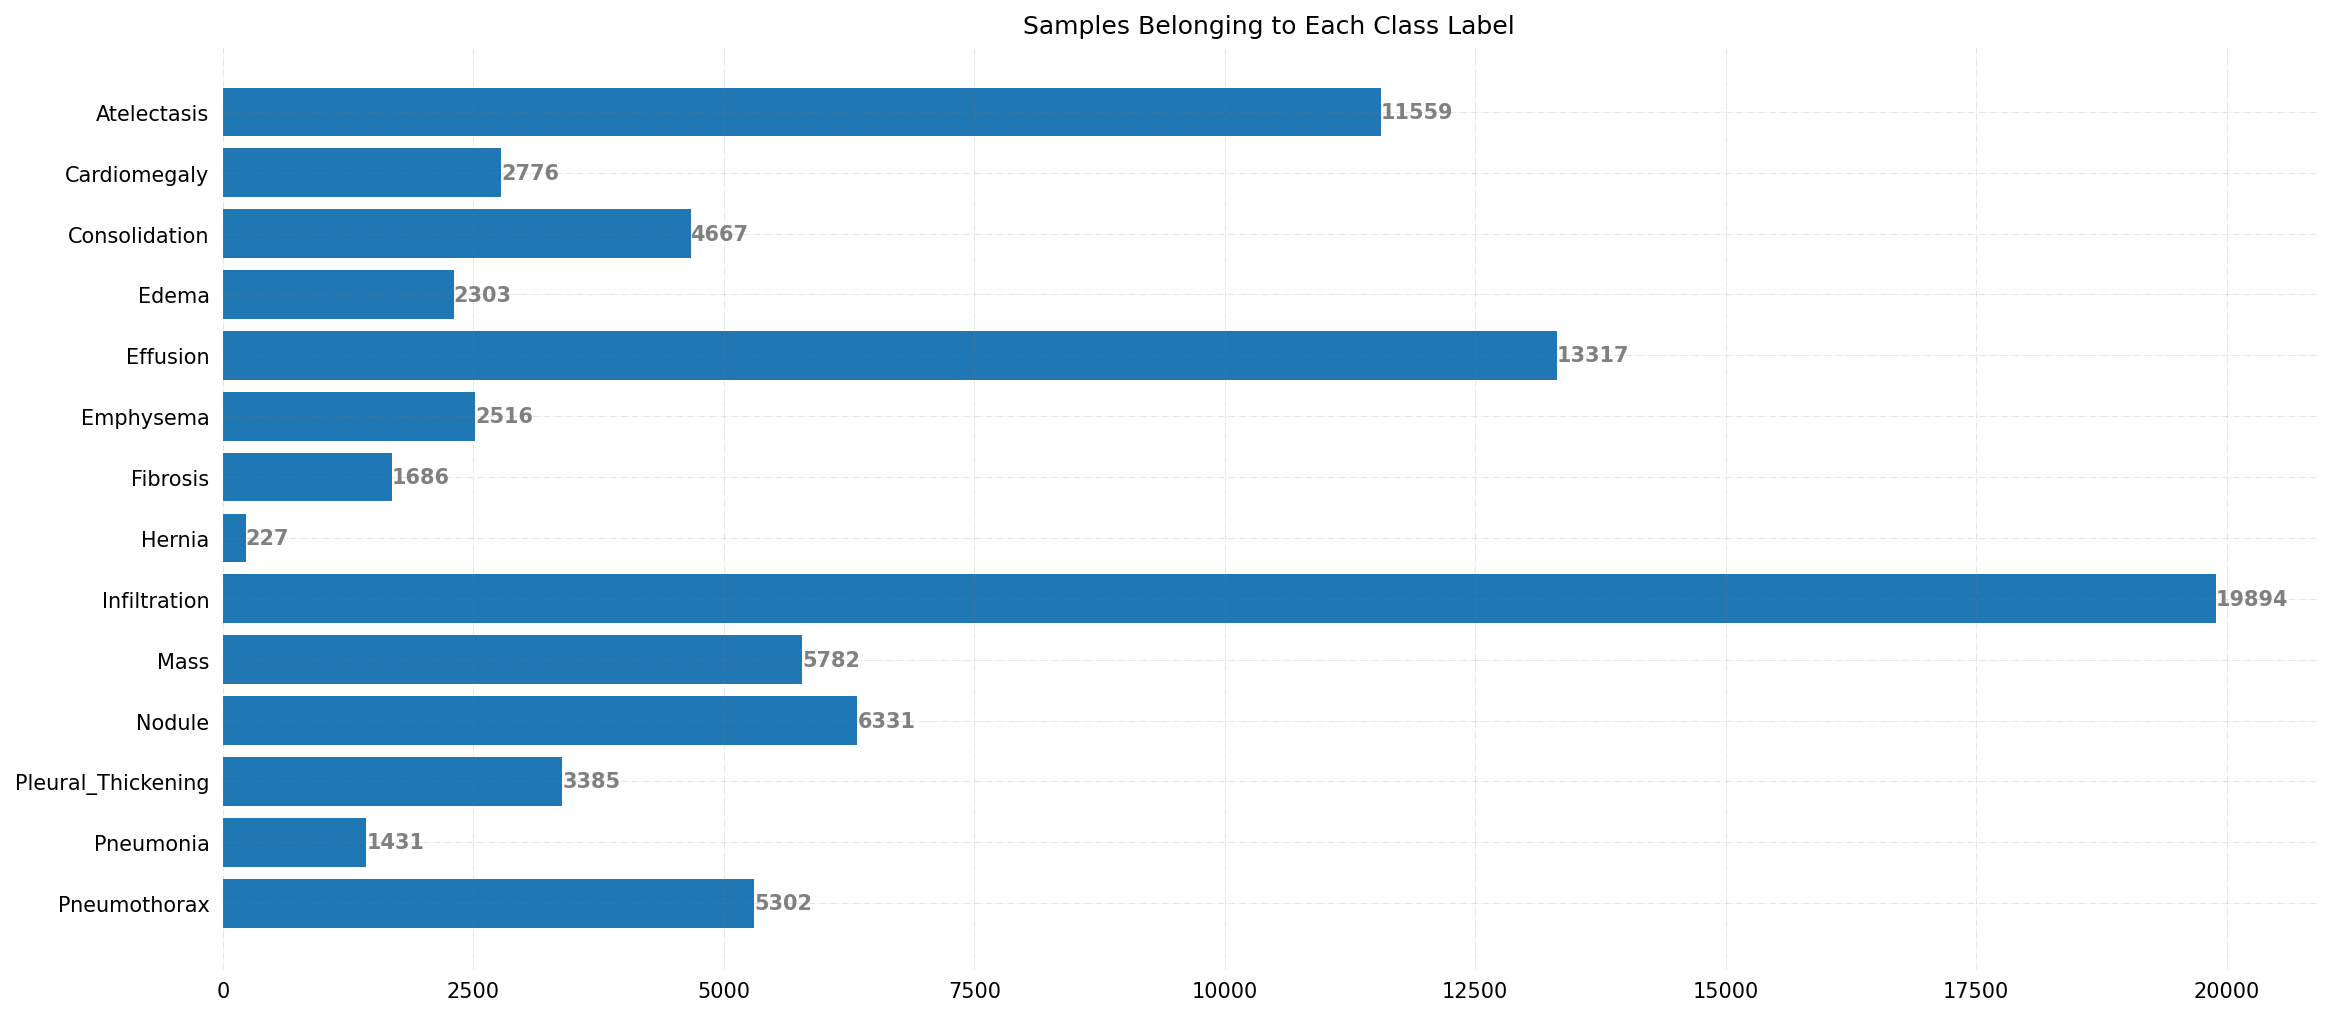

In [9]:
SAMPLES_PER_CLASS = dict()

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = 0

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = int(df[label].sum())
    
plot_class_samples(SAMPLES_PER_CLASS)

In [10]:
def apply_sharpening(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output

def apply_min_max_scaling(image):
    from skimage.transform import rescale
    image = (image - image.min()) / (image.max() - image.min())
    return image

def one_minus_one_normalization(image):
    normalized_image = (image.astype(np.float32) / 127.5) - 1
    return normalized_image

In [11]:
train_data_generator = ImageDataGenerator(
#     rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    fill_mode = "constant",
    preprocessing_function = one_minus_one_normalization
)
val_data_generator = ImageDataGenerator(
#     rescale = 1. / 255, 
    preprocessing_function = one_minus_one_normalization
)
test_data_generator = ImageDataGenerator(
#     rescale = 1. / 255, 
    preprocessing_function = one_minus_one_normalization
)


def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen

In [12]:
train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

Found 37266 validated image filenames.
Found 4141 validated image filenames.
Found 10352 validated image filenames.


In [13]:
# class MultiLabelCrossEntropy:
#     def __init__(self, labels: DataFrame, epsilon = 1e-7):
#         self.epsilon = epsilon
#         self.N = labels.shape[0]
        
#         self.freq_pos = np.sum(labels == 1, axis=0)
#         self.freq_neg = np.sum(labels == 0, axis=0)
#         self.pos_weights = self.freq_neg  / self.N
#         self.neg_weights = self.freq_pos  / self.N
        
#         self.print_class_weights()
        
#     def calculate_loss(self, true_y, pred_y):
#         loss = 0.0
#         for i in range(len(self.pos_weights)):
#             loss += (-1 * K.mean(self.pos_weights[i] * true_y[:,i] * K.log(pred_y[:,i] + self.epsilon))) + (-1 * K.mean(self.neg_weights[i] * (1 - true_y[:,i]) * K.log(1 - pred_y[:,i] + self.epsilon)))
        
#         return loss
        
#     def contribution(self):
#         return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
    
#     def print_class_weights(self):
#         tabulated_weights_data = []
#         for i, l in zip(range(15), CLASS_LABELS):
#             label_samples_percentage = (self.freq_pos[i] / SAMPLES_PER_CLASS[l]) * 100 
#             row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[l], self.freq_pos[i], label_samples_percentage, self.freq_neg[i], self.pos_weights[i], self.neg_weights[i]]
#             tabulated_weights_data.append(row)
            
#         print(tabulate(
#             tabulated_weights_data, 
#             headers = ["Class", "Total Samples", "Positive Samples [Train]",  "Sample Percentage [Train]","Negative Frequency [Train]", "Positive Weight", "Negative Weight"], 
#             tablefmt = "github", 
#             numalign = "left"
#         ))

        
# MLCE_Loss_With_Class_Weights = MultiLabelCrossEntropy(df_train[CLASS_LABELS])

In [14]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True)

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy', threshold = 0.5),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = len(CLASS_LABELS), thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

DEFINED_OPTIMIZERS = {
    "SGD" : tf.keras.optimizers.legacy.SGD(learning_rate = LEARNING_RATE, decay = 1e-6, momentum = 0.9, nesterov = True),
    "ADAM" : tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999,),
    "RMSPROP" : tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
    "NADAM" : tf.keras.optimizers.Nadam(learning_rate = LEARNING_RATE,),
    "ADAMAX" : tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE,),
    "ADAGRAD" : tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE,)
}

DEFINED_LOSSES = {
    "BCE" : "binary_crossentropy", 
#     "MLBCE_CW" : MLCE_Loss_With_Class_Weights.calculate_loss
}

In [15]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

MODEL_NAME = "MobileNetV2"
base_model = MobileNetV2(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet" if USE_TRANSFER_LEARNING else None
)

classifier = Sequential()
# classifier.add(Flatten())
classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
classifier.add(Dropout(0.2))

classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(50))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(len(CLASS_LABELS), activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = classifier(base_model.output))
# model.load_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = DEFINED_OPTIMIZERS["ADAM"],
#     loss = DEFINED_LOSSES["MLBCE_CW"],
    loss = DEFINED_LOSSES["BCE"],
    metrics = METRICS,
)

USE_CLASS_WEIGHTS_IN_MODEL_FIT = False

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
start_time = time.time()

history = model.fit(
    epochs = EPOCHS,
    x = train_gen,
    validation_data = valid_gen,  
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_steps = valid_gen.n / valid_gen.batch_size,  
    shuffle = False,
    callbacks = None,
    verbose = 1,
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/5
2329/2329 [==============================] - 2813s 1s/step - loss: 0.3602 - tp: 9833.0000 - fp: 23993.0000 - tn: 439406.0000 - fn: 48492.0000 - binary_accuracy: 0.8611 - precision: 0.2315 - recall: 0.4624 - auc: 0.5593 - prc: 0.2240 - val_loss: 0.3033 - val_tp: 1579.0000 - val_fp: 2037.0000 - val_tn: 49405.0000 - val_fn: 4953.0000 - val_binary_accuracy: 0.8794 - val_precision: 0.3447 - val_recall: 0.4979 - val_auc: 0.6041 - val_prc: 0.3484
Epoch 2/5
2329/2329 [==============================] - 2623s 1s/step - loss: 0.2811 - tp: 11043.0000 - fp: 8781.0000 - tn: 454618.0000 - fn: 47282.0000 - binary_accuracy: 0.8925 - precision: 0.4281 - recall: 0.4270 - auc: 0.6394 - prc: 0.3952 - val_loss: 0.2744 - val_tp: 1244.0000 - val_fp: 944.0000 - val_tn: 50498.0000 - val_fn: 5288.0000 - val_binary_accuracy: 0.8925 - val_precision: 0.4366 - val_recall: 0.4259 - val_auc: 0.6571 - val_prc: 0.4148
Epoch 3/5
2329/2329 [==============================] - 2653s 1s/step - loss: 0.2672 - tp: 137

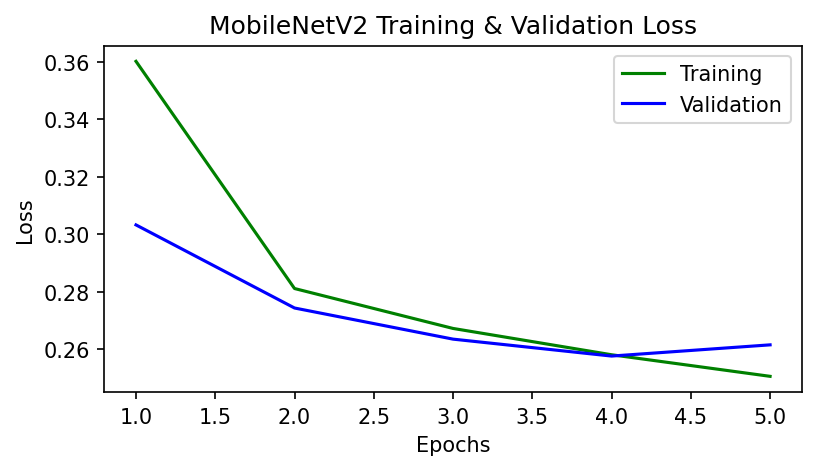

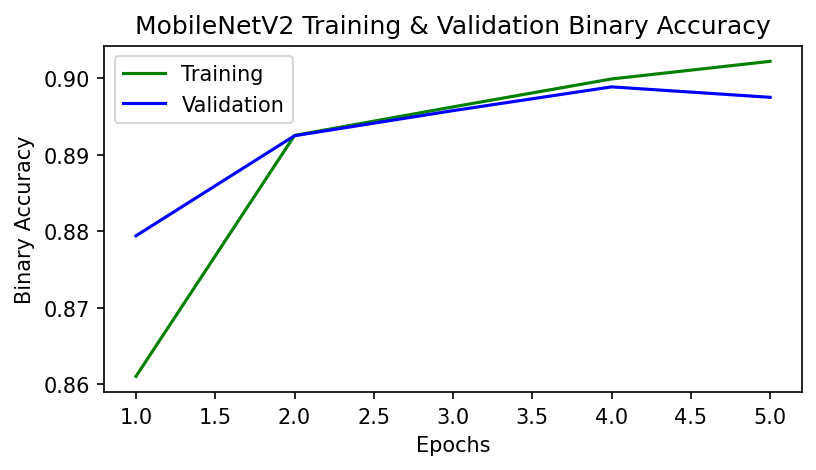

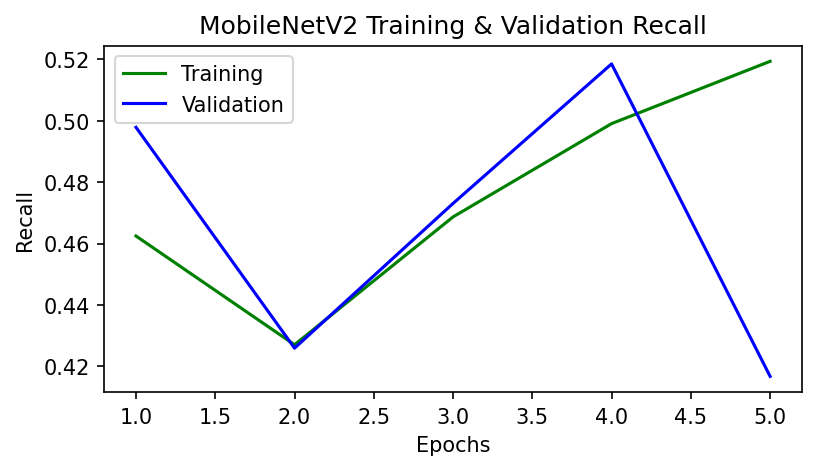

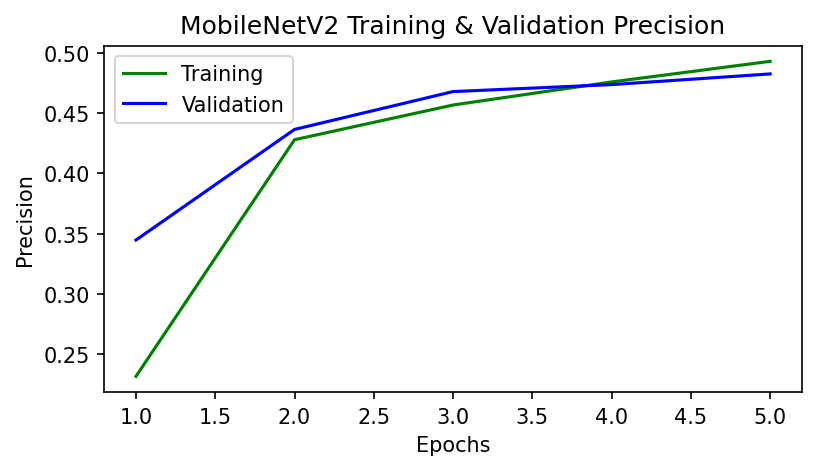

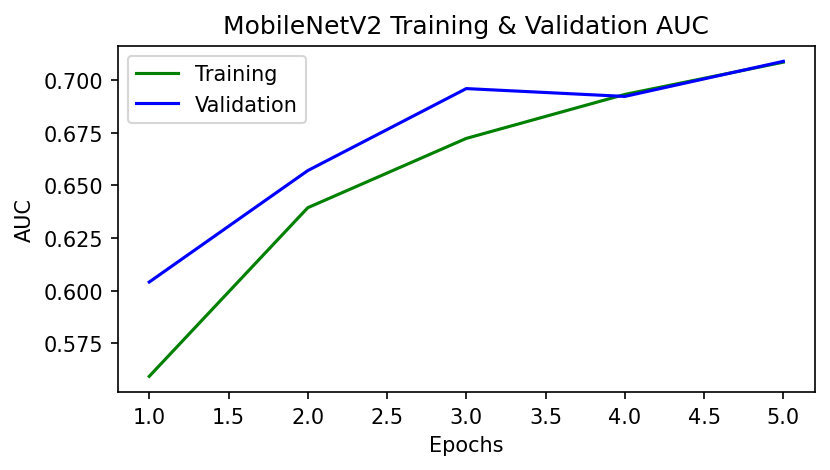

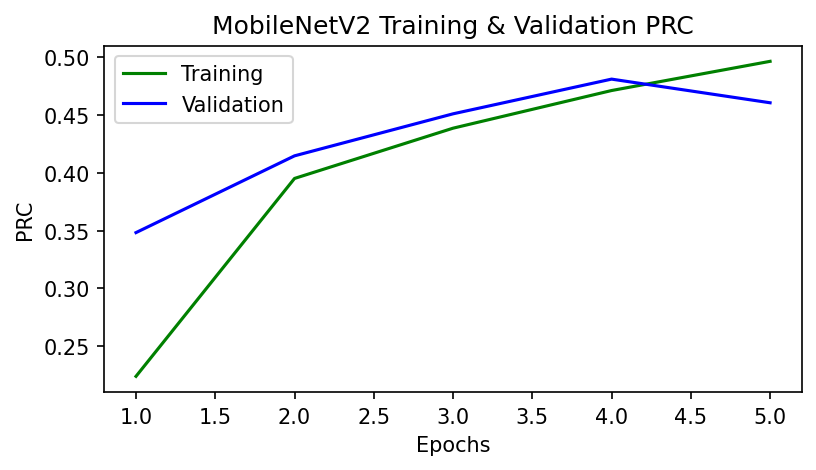

In [17]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [18]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [19]:
# model.save_weights(f"./saved_weights_MLBCE/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_gen)

647/647 [==============================] - 351s 543ms/step - loss: 0.2636 - tp: 3365.0000 - fp: 2048.0000 - tn: 126561.0000 - fn: 12954.0000 - binary_accuracy: 0.8965 - precision: 0.4824 - recall: 0.4085 - auc: 0.7083 - prc: 0.4520


In [20]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.26364368200302124

True Positives: 	3365.0
False Positives: 	2048.0
True Negatives: 	126561.0
False Negatives: 	12954.0

Binary Accuracy: 	89.64865207672119
Average Recall: 	20.62013603774741
Average Precision: 	62.16515795307593
F1-Score: 		30.968157555678264
Average Specificity: 	98.40757645265883

AUC: 			70.83012461662292
AUC-PR: 		45.20394504070282


In [21]:
test_gen.reset()
predictions = model.predict(test_gen)

647/647 [==============================] - 230s 355ms/step


In [22]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [23]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

BETA: 1, THRESHOLD: 0.1
Binary Accuracy: 	89.64865207672119 % 
Recall: 		82.85434246063232 % 
Precision: 		25.932106375694275 % 
F1-Score: 		39.50100839138031 %

BETA: 1, THRESHOLD: 0.2
Binary Accuracy: 	89.64865207672119 % 
Recall: 		61.382436752319336 % 
Precision: 		37.78288960456848 % 
F1-Score: 		46.77452743053436 %

BETA: 1, THRESHOLD: 0.3
Binary Accuracy: 	89.64865207672119 % 
Recall: 		40.85421860218048 % 
Precision: 		48.23818802833557 % 
F1-Score: 		44.240206480026245 %

BETA: 1, THRESHOLD: 0.4
Binary Accuracy: 	89.64865207672119 % 
Recall: 		28.984618186950684 % 
Precision: 		56.44391179084778 % 
F1-Score: 		38.30113708972931 %

BETA: 1, THRESHOLD: 0.5
Binary Accuracy: 	89.64865207672119 % 
Recall: 		20.620135962963104 % 
Precision: 		62.16515898704529 % 
F1-Score: 		30.968153476715088 %

BETA: 1, THRESHOLD: 0.6
Binary Accuracy: 	89.64865207672119 % 
Recall: 		13.444451987743378 % 
Precision: 		69.08060312271118 % 
F1-Score: 		22.50833362340927 %

BETA: 1, THRESHOLD: 0.7
Bin

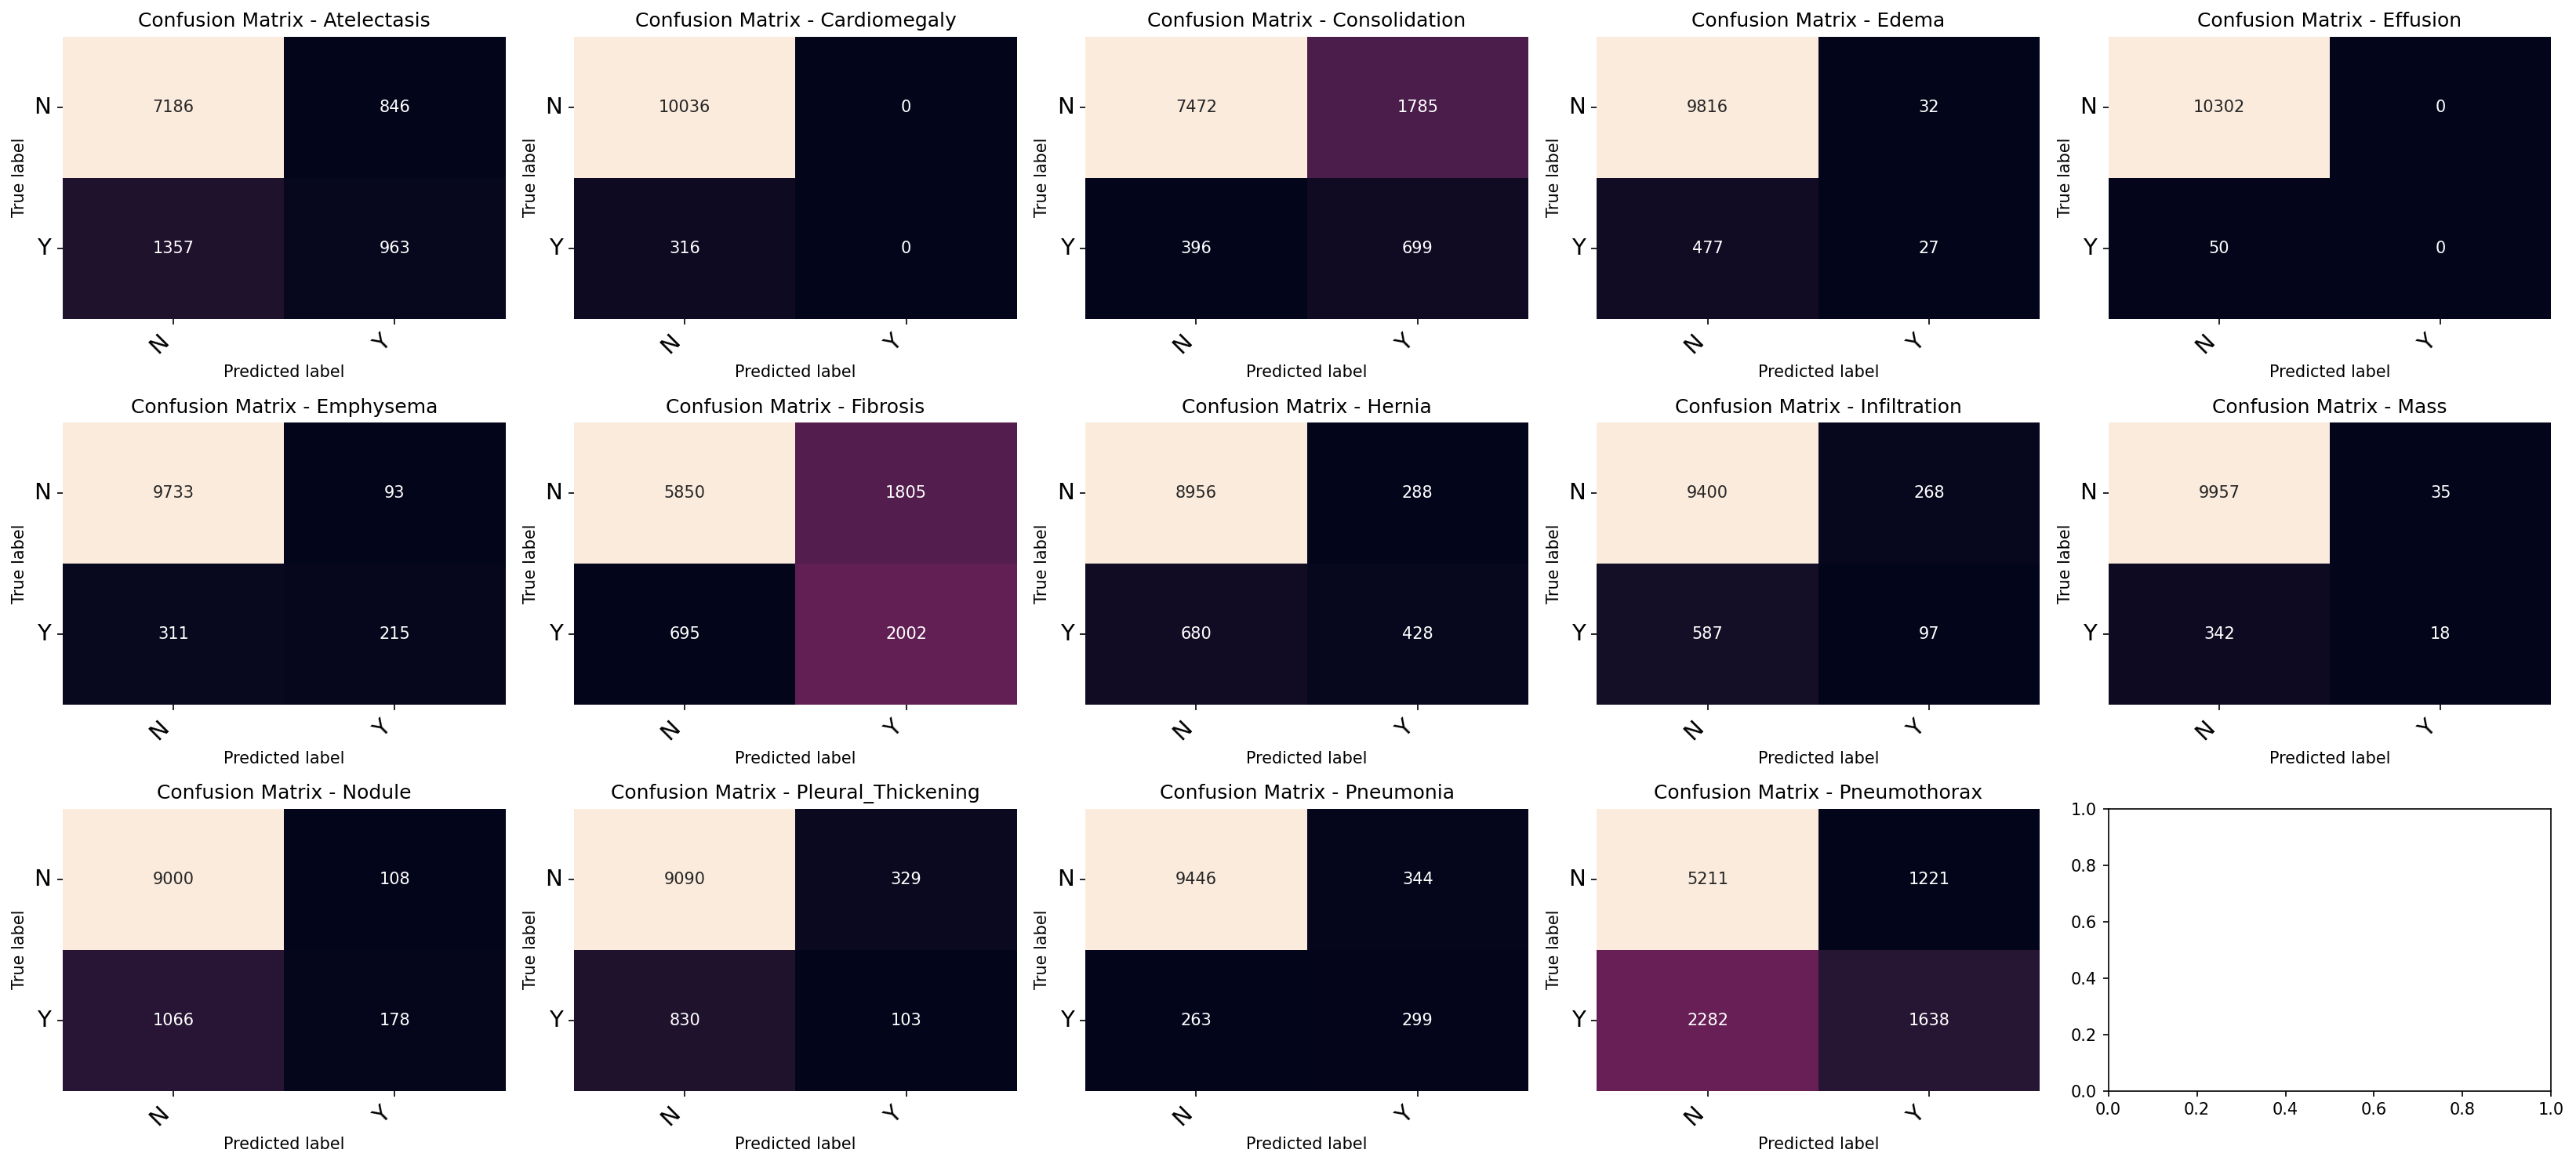

In [24]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)


threshold = 0.3
y_test = test_gen.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

[MobileNetV2 with 5 Epochs] - Average AUC: 0.7795178091827986


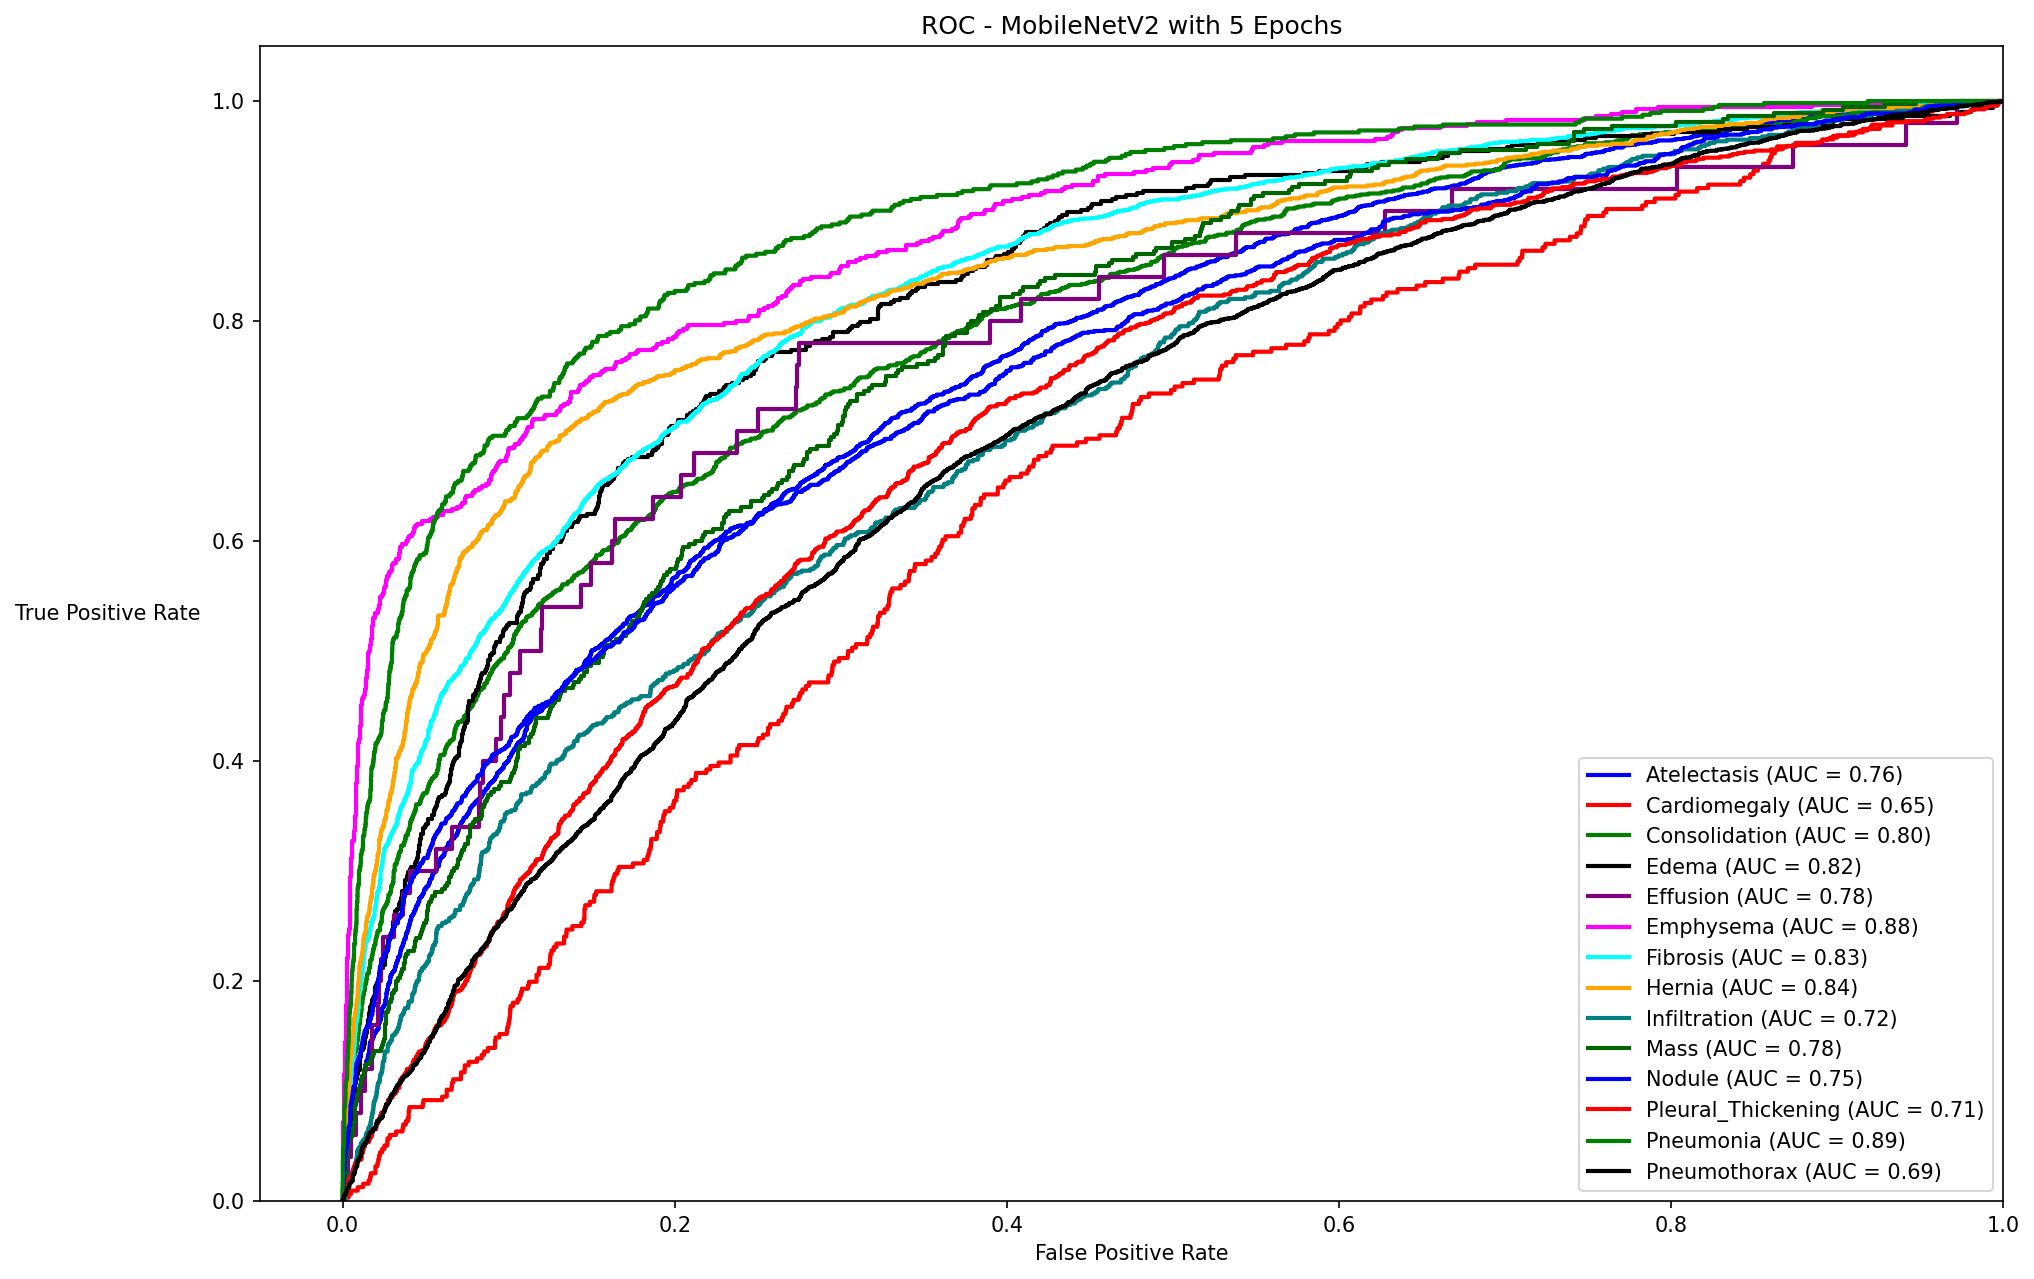

In [25]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value

print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / len(CLASS_LABELS)}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate', rotation = 0, labelpad = 50)
plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
plt.legend(loc = "lower right")
plt.show()